In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/per

In [2]:
pip install --upgrade tensorflow


Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import tensorflow as tf
from keras import backend as K
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import plot_model
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import *

In [4]:
#preprocessing
base_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray'

print('Contents of base directory:')
print(os.listdir(base_dir))

print('\nContents of train directory:')
print(os.listdir(f'{base_dir}/train'))

print('\nContents of val directory:')
print(os.listdir(f'{base_dir}/val'))

print('\nContents of test directory:')
print(os.listdir(f'{base_dir}/test'))

Contents of base directory:
['chest_xray', '__MACOSX', 'val', 'test', 'train']

Contents of train directory:
['PNEUMONIA', 'NORMAL']

Contents of val directory:
['PNEUMONIA', 'NORMAL']

Contents of test directory:
['PNEUMONIA', 'NORMAL']


In [5]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

#Directory with training NORMAL/PNEUMONIA pictures
train_NORMAL_dir = os.path.join(train_dir, 'NORMAL')
train_PNEUMONIA_dir = os.path.join(train_dir, 'PNEUMONIA')

#Directory with validation NORMAL/PNEUMONIA pictures
val_NORMAL_dir = os.path.join(val_dir, 'NORMAL')
val_PNEUMONIA_dir = os.path.join(val_dir, 'PNEUMONIA')

#Directory with test NORMAL/PNEUMONIA pictures
test_NORMAL_dir = os.path.join(test_dir, 'NORMAL')
test_PNEUMONIA_dir = os.path.join(test_dir, 'PNEUMONIA')

In [6]:
train_NORMAL_fnames = os.listdir(train_NORMAL_dir)
train_PNEUMONIA_fnames = os.listdir(train_PNEUMONIA_dir)

print(train_NORMAL_fnames[:5])
print(train_PNEUMONIA_fnames[:5])

['NORMAL2-IM-0771-0001.jpeg', 'NORMAL2-IM-1294-0001-0002.jpeg', 'IM-0675-0001.jpeg', 'NORMAL2-IM-1169-0001.jpeg', 'IM-0421-0001.jpeg']
['person1180_virus_2010.jpeg', 'person1230_virus_2081.jpeg', 'person1513_virus_2632.jpeg', 'person124_virus_238.jpeg', 'person746_virus_1369.jpeg']


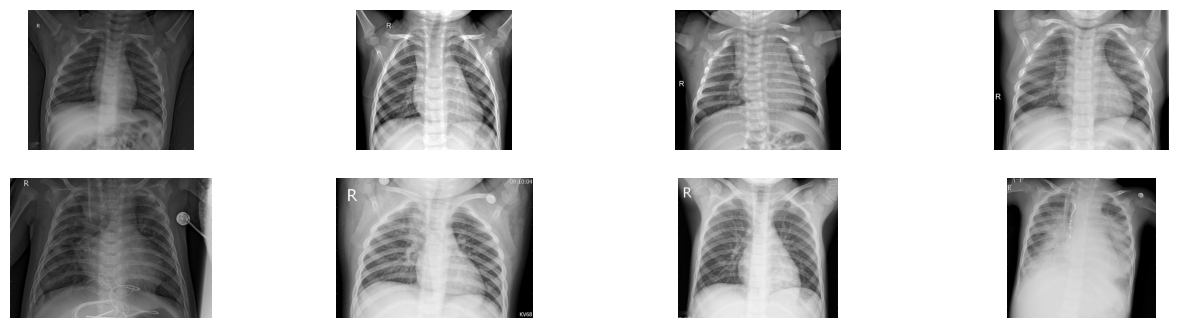

In [7]:
nrows = 2
ncols = 4

pic_index = 0 #Index for iterating over images

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*2)
labels = ['NORMAL','PNEUMONIA']

pic_index+=4

next_NORMAL_pix = [os.path.join(train_NORMAL_dir, fname) 
                for fname in train_NORMAL_fnames[pic_index-4:pic_index]]

next_PNEUMONIA_pix = [os.path.join(train_PNEUMONIA_dir, fname) 
                for fname in train_PNEUMONIA_fnames[pic_index-4:pic_index]]

for i, img_path in enumerate(next_NORMAL_pix+next_PNEUMONIA_pix):
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off')

  img = mpimg.imread(img_path)
  plt.imshow(img, cmap='gray')

plt.show();

In [8]:
print('total training NORMAL images :', len(os.listdir(train_NORMAL_dir)))
print('total training PNEUMONIA images :', len(os.listdir(train_PNEUMONIA_dir)))

print('total validation NORMAL images :', len(os.listdir(val_NORMAL_dir)))
print('total validation PNEUMONIA images :', len(os.listdir(val_PNEUMONIA_dir)))

print('total test NORMAL images :', len(os.listdir(test_NORMAL_dir)))
print('total test PNEUMONIA images :', len(os.listdir(test_PNEUMONIA_dir)))

total training NORMAL images : 1341
total training PNEUMONIA images : 3875
total validation NORMAL images : 8
total validation PNEUMONIA images : 8
total test NORMAL images : 234
total test PNEUMONIA images : 390


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


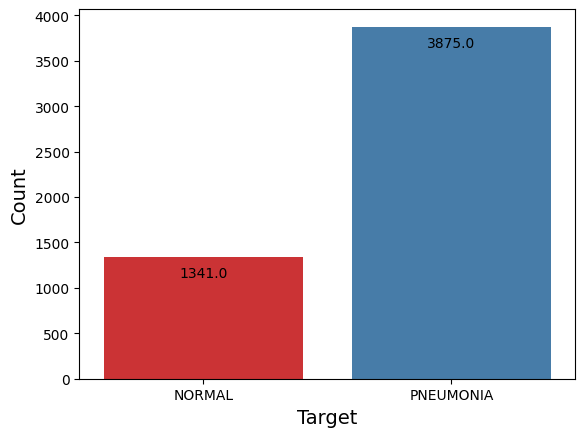

In [9]:
ax = sns.barplot(x = ['NORMAL', 'PNEUMONIA'], y = [len(os.listdir(train_NORMAL_dir)), len(os.listdir(train_PNEUMONIA_dir))]
            , palette = 'Set1')
for p in ax.patches:
    ax.annotate(format(p.get_height()), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, -12), 
                   textcoords = 'offset points')
plt.xlabel('Target', size=14)
plt.ylabel('Count', size=14);

In [10]:
from sklearn.model_selection import train_test_split

# Define image dimensions and batch size
IMG_HEIGHT, IMG_WIDTH = 150, 150
BATCH_SIZE = 32

# Data generator for normalization
datagen = ImageDataGenerator(rescale=1.0 / 255)

# Load the full training data
train_data = datagen.flow_from_directory( #this function automatically calculates train_data.samples (=5216) / batch_size(=32) -> len(train_data) = 164
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE, 
    class_mode="binary",
    shuffle=True,
    color_mode="grayscale" # Ensure grayscale images
)

# Collect all images and labels from the generator
X_train_full = []
y_train_full = []

for i in range(len(train_data)):
    images, labels = train_data[i]
    X_train_full.extend(images)
    y_train_full.extend(labels)
    if len(X_train_full) >= train_data.samples:  # Stop once all data is collected
        break

# Convert lists to numpy arrays
X_train_full = np.array(X_train_full)
y_train_full = np.array(y_train_full)

# Split into training and validation sets (80/20 split)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=42
)

# Print split sizes
print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")

Found 5216 images belonging to 2 classes.
Training set size: 4172
Validation set size: 1044


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Define the CNN architecture
model = Sequential([
    # Convolutional layer 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)), 
    MaxPooling2D(pool_size=(2, 2)),

    # Convolutional layer 2
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Convolutional layer 3
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten layer
    Flatten(),

    # Fully connected dense layers
    Dense(128, activation='relu'),
    Dropout(0.5),  # Dropout for regularization
    Dense(64, activation='relu'),
    Dropout(0.5),

    # Output layer
    Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),  # Adam optimizer with learning rate
    loss='binary_crossentropy',          # Binary cross-entropy for binary classification
    metrics=['accuracy']                 # Evaluate accuracy during training
)

# Display the model summary
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,836,097 (18.45 MB)

 Trainable params: 4,836,097 (18.45 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Training the model
EPOCHS = 20
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1  # Display progress during training
)

Epoch 1/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 105s 788ms/step - accuracy: 0.7356 - loss: 0.5535 - val_accuracy: 0.9607 - val_loss: 0.1200
Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 140s 779ms/step - accuracy: 0.9281 - loss: 0.1980 - val_accuracy: 0.8678 - val_loss: 0.3068
Epoch 3/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 105s 802ms/step - accuracy: 0.9422 - loss: 0.1663 - val_accuracy: 0.9732 - val_loss: 0.0903
Epoch 4/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 100s 767ms/step - accuracy: 0.9592 - loss: 0.1181 - val_accuracy: 0.9703 - val_loss: 0.0892
Epoch 5/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 143s 775ms/step - accuracy: 0.9664 - loss: 0.1041 - val_accuracy: 0.9751 - val_loss: 0.0835
Epoch 6/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 142s 775ms/step - accuracy: 0.9739 - loss: 0.0792 - val_accuracy: 0.9732 - val_loss: 0.0935
Epoch 7/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 101s 773ms/step - accuracy: 0.9667 - loss: 0.0975 - val_accuracy: 0.9722 - val_loss: 0.0973
Epoch 8/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 142s 772ms/step - accuracy: 0.9760 -

In [13]:
# Preprocess test data
test_datagen = ImageDataGenerator(rescale=1.0 / 255)  # Only normalize, no augmentation

# Load test data
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),  # Resize to match model input size
    batch_size=1,  # Batch size of 1 to make predictions easier to handle
    class_mode="binary",  # Binary classification: normal or pneumonia
    color_mode="grayscale",  # Ensure grayscale images
    shuffle=False  # No shuffle to maintain correspondence between predictions and filenames
)

# Print test set size
print(f"Test set size: {test_data.samples}")

Found 624 images belonging to 2 classes.
Test set size: 624


  6/624 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.4083 - loss: 3.6866

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


624/624 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.5350 - loss: 5.1862
Test Accuracy: 0.7564
Test Loss: 2.9188
624/624 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.98      0.36      0.52       234
   PNEUMONIA       0.72      0.99      0.84       390

    accuracy                           0.76       624
   macro avg       0.85      0.68      0.68       624
weighted avg       0.82      0.76      0.72       624



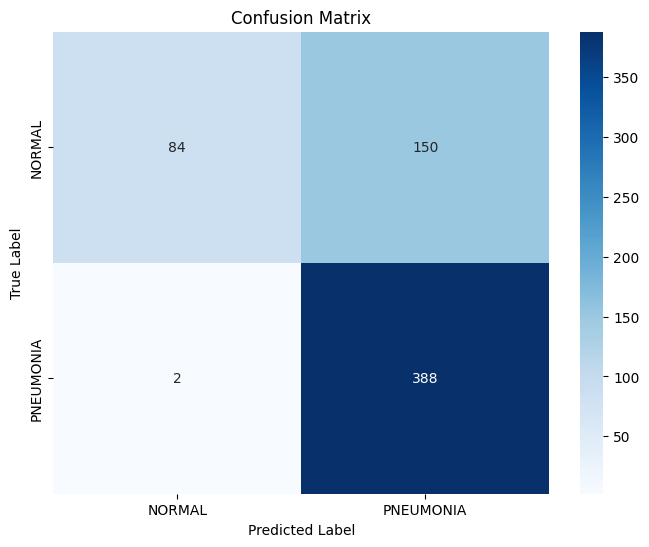

In [14]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_data, verbose=1)

# Print the test accuracy and loss
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Generate predictions for the test data
test_data.reset()  # Reset the test generator to ensure predictions match correctly
y_pred = model.predict(test_data)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()  # Convert probabilities to binary classes

# Extract true labels from the test data
y_true = test_data.classes

# Generate a classification report
from sklearn.metrics import classification_report, confusion_matrix

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=test_data.class_indices.keys()))

# Create a confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=test_data.class_indices.keys(), yticklabels=test_data.class_indices.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

/tmp/ipykernel_30/1583102851.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot  (epochs, acc, 'bo', color = '#ff0066')
/tmp/ipykernel_30/1583102851.py:26: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot  (epochs, loss, 'bo', color = '#ff0066')


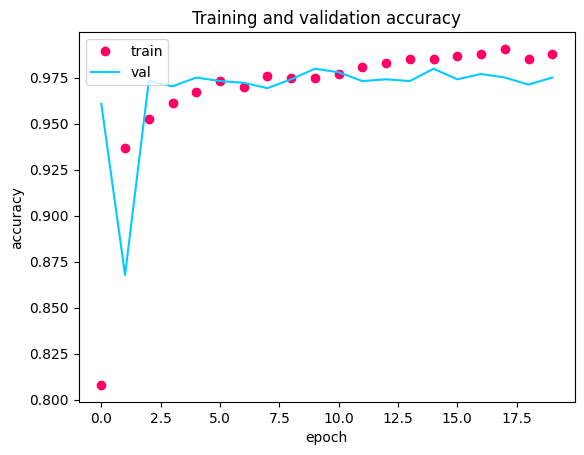

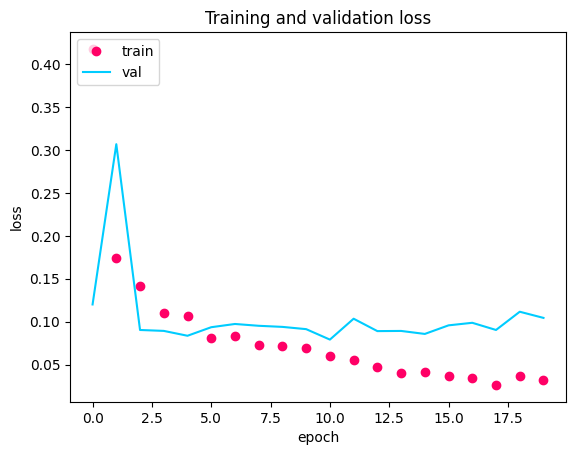

In [15]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc, 'bo', color = '#ff0066')
plt.plot  (epochs, val_acc, color = '#00ccff')
plt.title ('Training and validation accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss, 'bo', color = '#ff0066')
plt.plot  (epochs, val_loss, color = '#00ccff')
plt.legend(['train', 'val'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title ('Training and validation loss');

In [ ]:
test_labels = test_generator.classes  
predictions = model.predict(test_generator)  
predicted_classes = np.argmax(predictions, axis=1) 
num_images_to_visualize = 49
classes=list(test_generator.class_indices.keys())
images, labels = next(test_generator)  
images = images[:num_images_to_visualize]
labels = labels[:num_images_to_visualize]
predicted_classes = predicted_classes[:num_images_to_visualize]

plt.figure(figsize=(20,20))
for i in range(len(images)):
    plt.subplot(7, 7, i + 1)  
    plt.imshow(images[i])
    true_label = classes[test_labels[i]] 
    predicted_label = categories[predicted_classes[i]] 
    plt.title(f"P: {predicted_label}\nT: {true_label}", fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()